### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data - Airbnb daily prices is used here
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

## Importing libraries

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

I sourced this data from http://insideairbnb.com/get-the-data/. They have Airbnb data for many cities and I will be using this data for time analysis. This is everyday price for the listings in New York City and the data is from 05-December 2022 to 16-Dec 2023. I believe its the price if you book it now and might change. As this has multiple listings, I will be using mean to use this data date and price_adjusted considering, its different from the price

In [2]:
path=r'C:\Users\S Keerthana\Downloads'

In [3]:
df =pd.read_csv(os.path.join(path,'calendar.csv.gz'),parse_dates=['date'],index_col=False)

In [4]:
df

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,5136,2022-12-04,f,$275.00,$275.00,21.0,1125.0
1,2595,2022-12-05,t,$175.00,$175.00,30.0,1125.0
2,2595,2022-12-06,t,$175.00,$175.00,30.0,1125.0
3,2595,2022-12-07,t,$175.00,$175.00,30.0,1125.0
4,2595,2022-12-08,t,$175.00,$175.00,30.0,1125.0
...,...,...,...,...,...,...,...
15154431,774126805810509248,2023-11-30,f,$499.00,$499.00,1.0,365.0
15154432,774126805810509248,2023-12-01,f,$499.00,$499.00,1.0,365.0
15154433,774126805810509248,2023-12-02,f,$499.00,$499.00,1.0,365.0
15154434,774126805810509248,2023-12-03,f,$499.00,$499.00,1.0,365.0


In [5]:
df.columns

Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15154436 entries, 0 to 15154435
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           object        
 4   adjusted_price  object        
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 809.3+ MB


In [7]:
df['date'].min()

Timestamp('2022-12-04 00:00:00')

In [8]:
# Check for duplicates in the main data

dups = df.duplicated()
dups.sum()


0

In [9]:
df['date'].max()

Timestamp('2023-12-04 00:00:00')

## creating new data frame with required data

In [10]:
df_date=df[['date','adjusted_price']]

In [11]:
df_date

,date,adjusted_price
0,2022-12-04,$275.00
1,2022-12-05,$175.00
2,2022-12-06,$175.00
3,2022-12-07,$175.00
4,2022-12-08,$175.00
...,...,...
15154431,2023-11-30,$499.00
15154432,2023-12-01,$499.00
15154433,2023-12-02,$499.00
15154434,2023-12-03,$499.00


Adjusted_price has the $ sign and to make it float, we need to remove it first

In [12]:
#replacing $ with empty space 
df_date['adjusted_price'] = df_date['adjusted_price'].str.replace('$', '')
df_date['adjusted_price'] = df_date['adjusted_price'].str.replace(',', '')

In [13]:
#Changing datatype

df_date['adjusted_price']=df_date['adjusted_price'].astype('float64')

In [14]:
df_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15154436 entries, 0 to 15154435
Data columns (total 2 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   adjusted_price  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 231.2 MB


In [15]:
# Setting date column as index

# Set the "Date" column as the index

from datetime import datetime

df_date['datetime'] = pd.to_datetime(df_date['date']) # Create a datetime column from "Date.""
df_date = df_date.set_index('datetime') # Set the datetime as the index of the dataframe.
df_date.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
df_date.head()

,adjusted_price
datetime,
2022-12-04,275.0
2022-12-05,175.0
2022-12-06,175.0
2022-12-07,175.0
2022-12-08,175.0


In [16]:
df_date.shape

(15154436, 1)

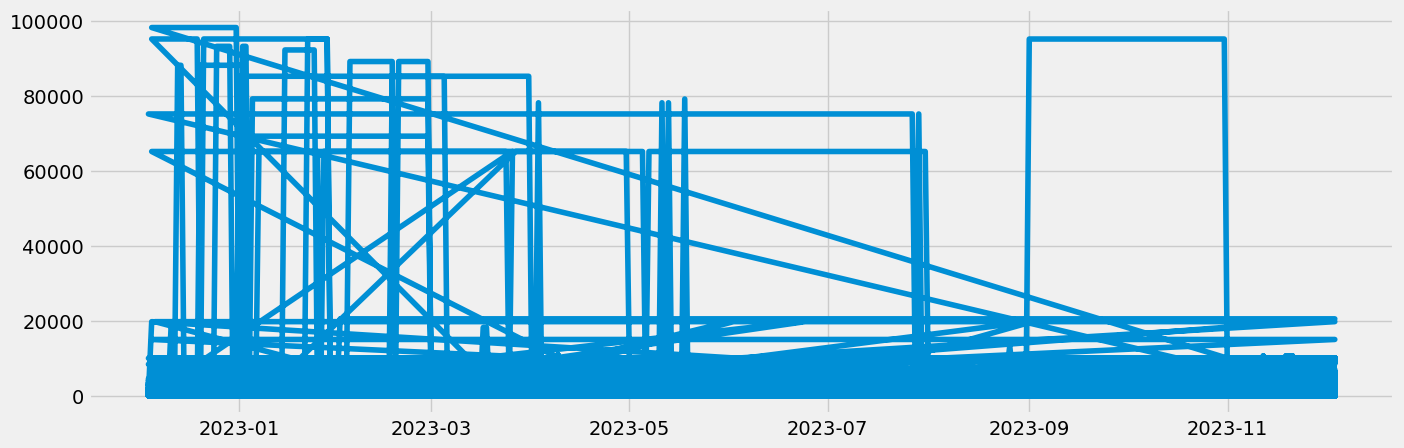

In [17]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(df_date)


## Cleaning and wrangling the data

In [18]:
# Check for missing values

df_date.isnull().sum() 

adjusted_price    4897
dtype: int64

In [19]:
#subsetting one with adjusted price and no NULL

df_sub=df_date[df_date['adjusted_price'].isnull()==False]

In [20]:
df_sub.shape

(15149539, 1)

In [21]:
df_sub.isnull().sum() 

adjusted_price    0
dtype: int64

In [22]:
# Check for duplicates

dups = df_sub.duplicated()
dups.sum()

# No dups!

15144825

Multiple listing might have similar prices for many days, its understandable to have duplicates. Hence before this, we will convert this to day wise mean and then check duplicates

In [23]:
# resampleing suggested

daily_data = df_sub.resample('D').mean()

In [24]:
daily_data

,adjusted_price
datetime,
2022-12-04,175.962712
2022-12-05,214.249018
2022-12-06,225.718168
2022-12-07,227.125617
2022-12-08,223.626738
...,...
2023-11-30,219.563488
2023-12-01,224.858857
2023-12-02,224.938199


In [25]:
# Checking for duplicates again

dups = daily_data.duplicated()
dups.sum()

# No dups!

0

In [26]:
#removing duplicates and moving a new data frame

data_clean=daily_data.drop_duplicates()

In [27]:
data_clean.shape

(366, 1)

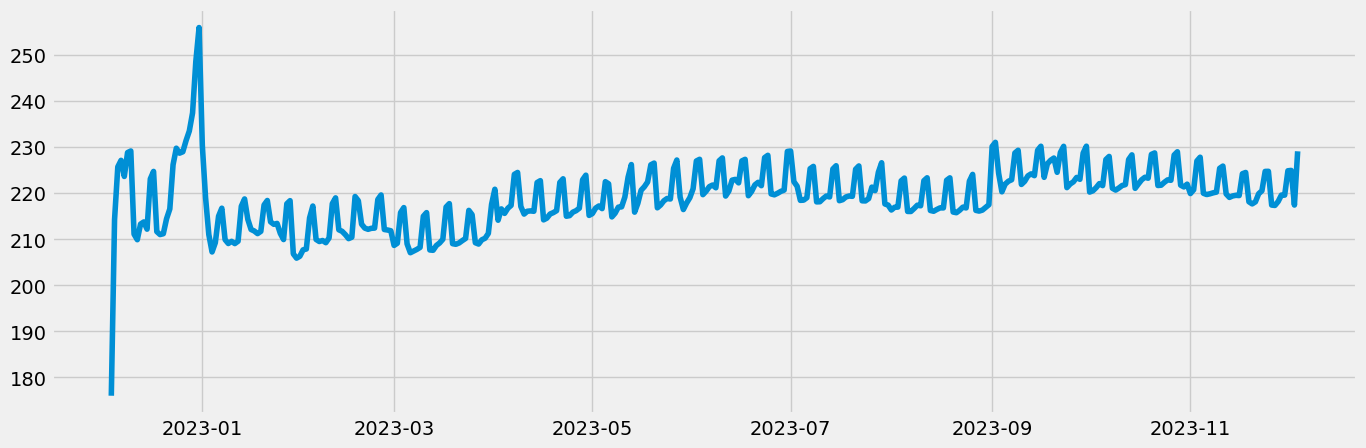

In [28]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_clean)

### 3. Time-series analysis: decomposition

In [29]:
# Decompose the time series using an additive model

decomp = sm.tsa.seasonal_decompose(data_clean, model='additive')

In [30]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

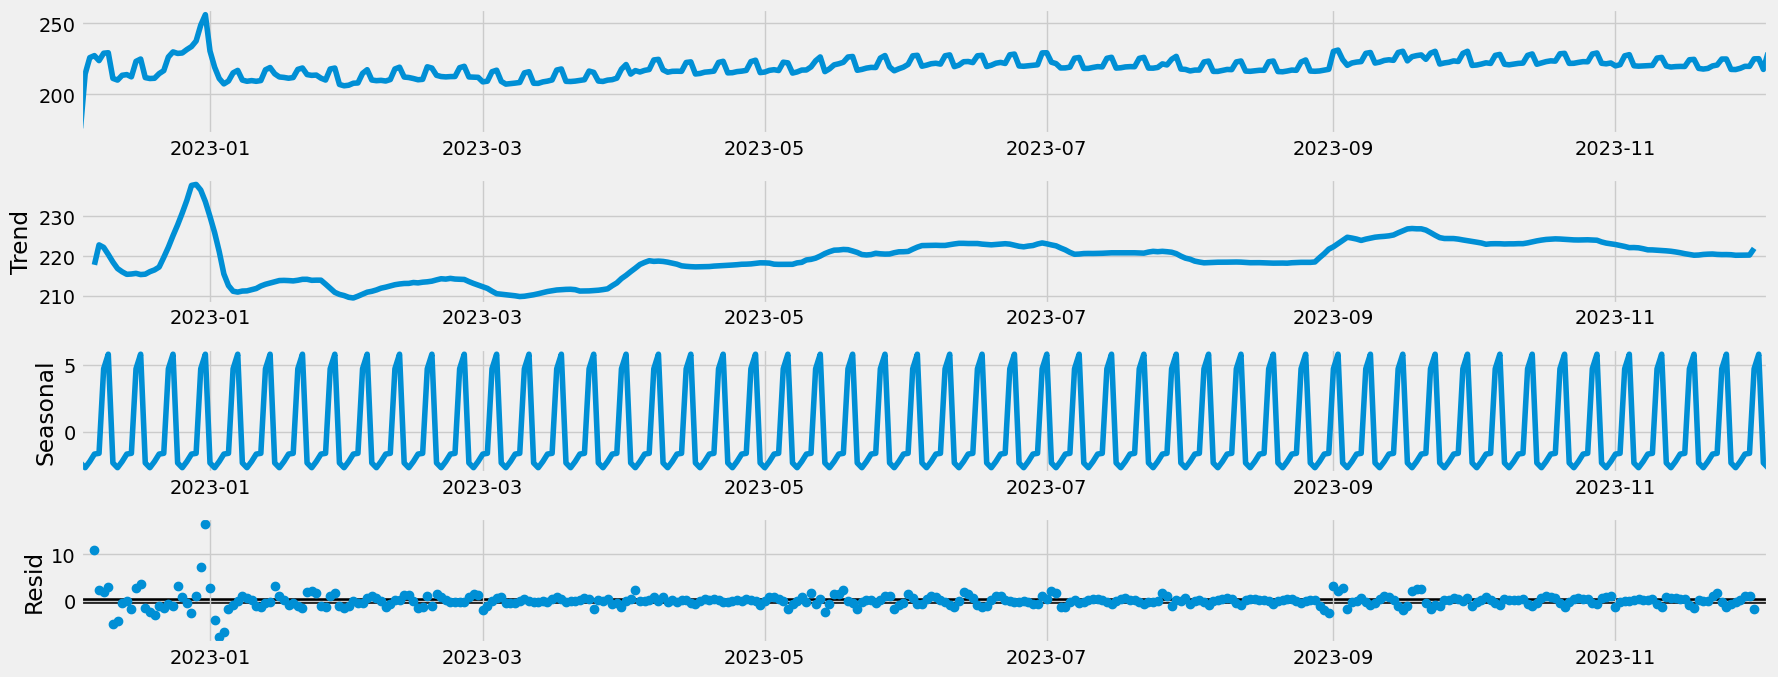

In [31]:
# Plot the separate components

decomp.plot()
plt.show()

### 4. Testing for stationarity

In [32]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. 

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_clean['adjusted_price'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.184441
p-value                          0.211941
Number of Lags Used             16.000000
Number of Observations Used    349.000000
Critical Value (1%)             -3.449227
Critical Value (5%)             -2.869857
Critical Value (10%)            -2.571201
dtype: float64


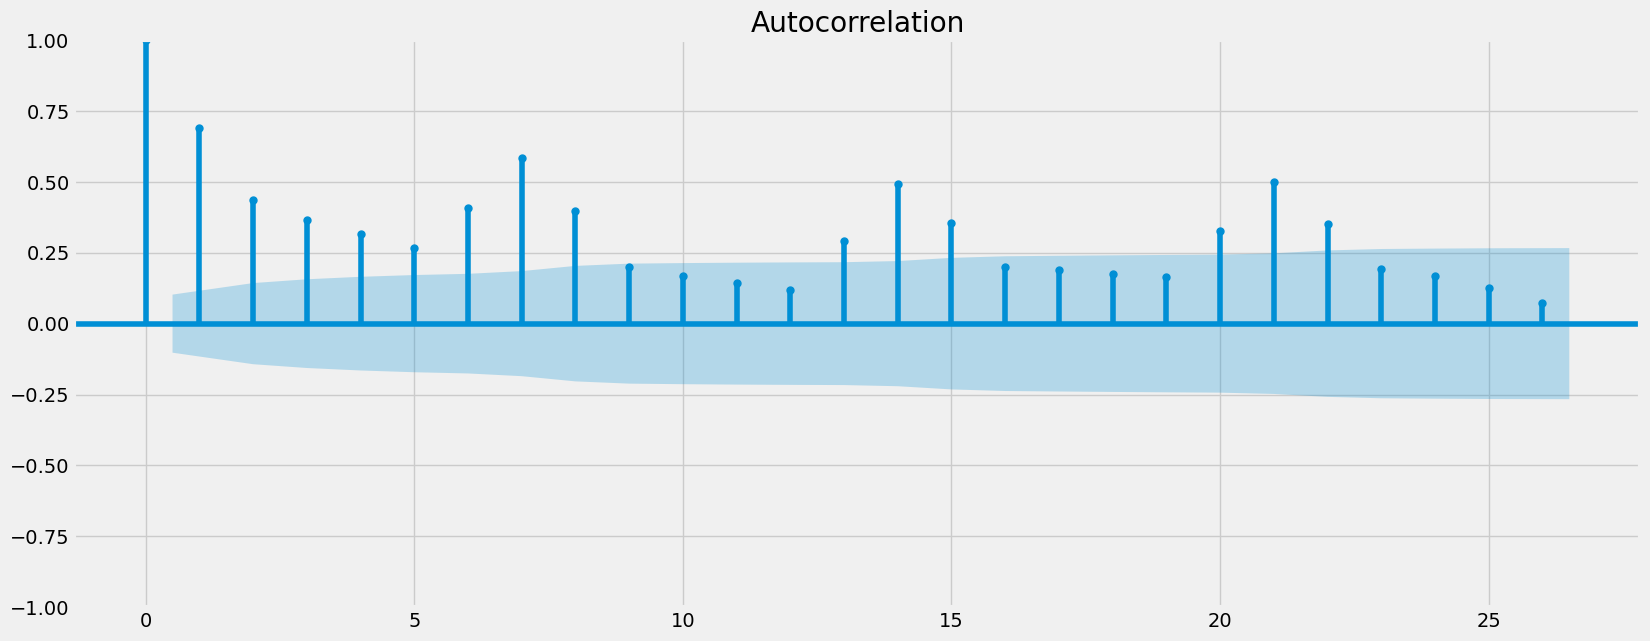

In [33]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_clean)
plt.show()

## Stationarizing the prices

In [34]:
data_diff = data_clean - data_clean.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [35]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [36]:
data_diff.head()

,adjusted_price
datetime,
2022-12-05,38.286306
2022-12-06,11.469150
2022-12-07,1.407449
2022-12-08,-3.498880
2022-12-09,5.191028


In [37]:
data_diff.columns

Index(['adjusted_price'], dtype='object')

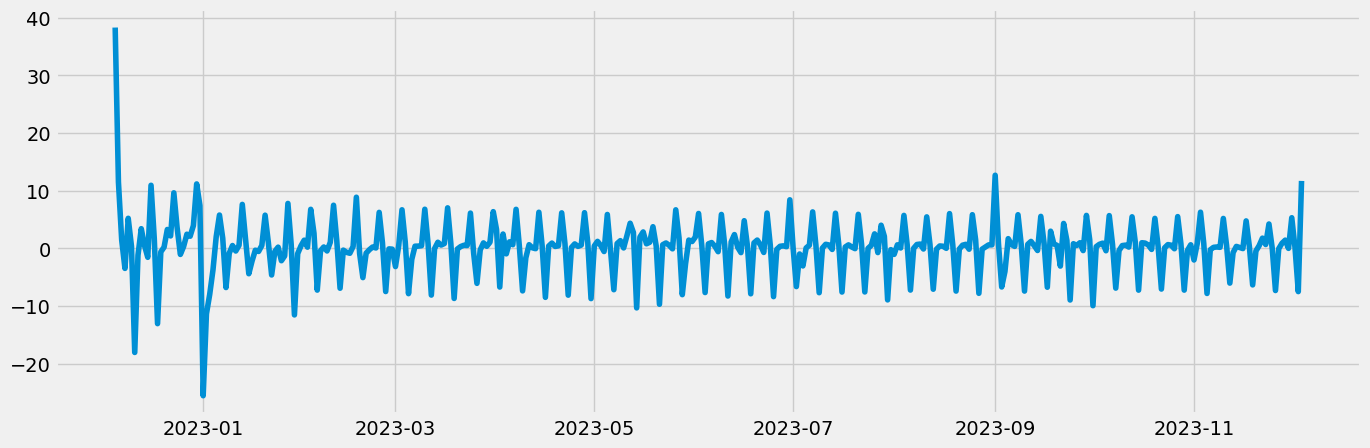

In [38]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [39]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -6.484830e+00
p-value                        1.268514e-08
Number of Lags Used            1.500000e+01
Number of Observations Used    3.490000e+02
Critical Value (1%)           -3.449227e+00
Critical Value (5%)           -2.869857e+00
Critical Value (10%)          -2.571201e+00
dtype: float64


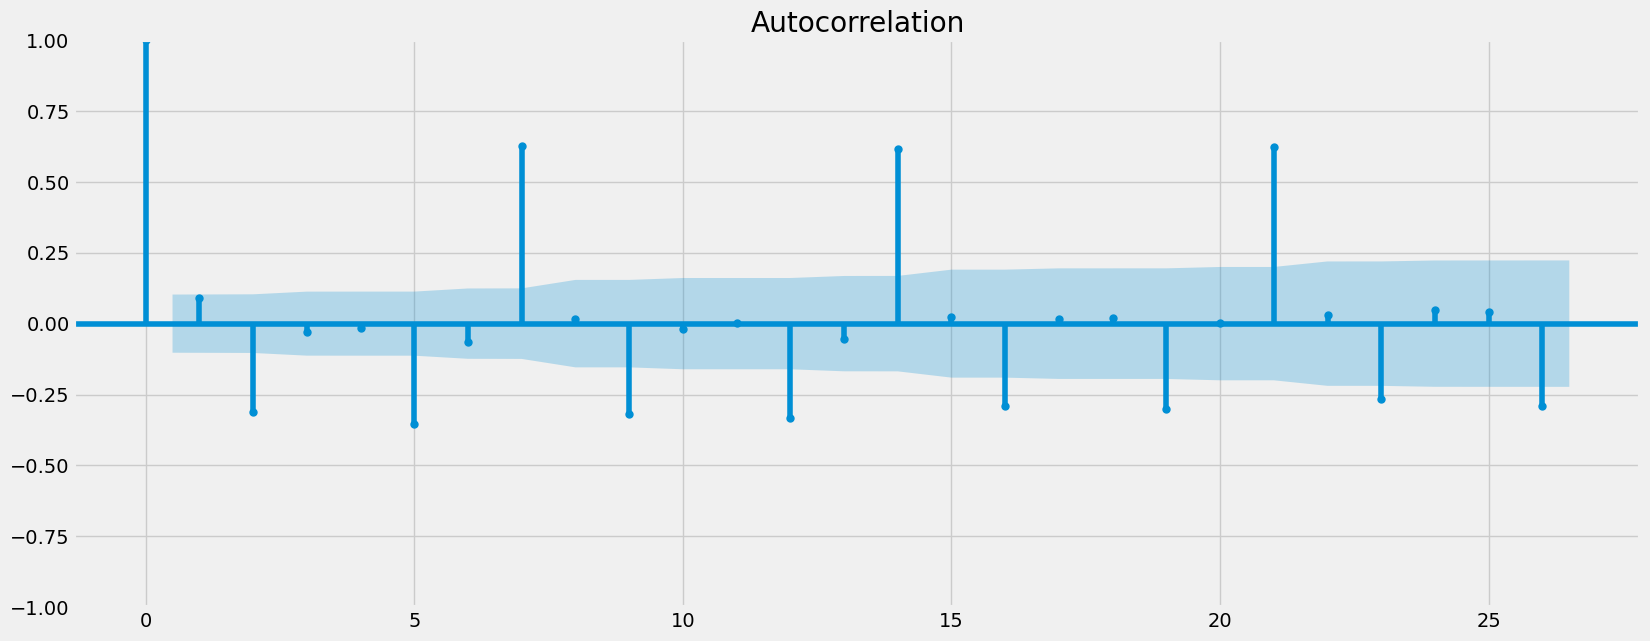

In [40]:
plot_acf(data_diff)
plt.show()

## Stationarizing again as the p-value is not less than 0.05 and test stats > critical value

In [41]:
data_diff_2 = data_diff - data_diff.shift(1) 
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [42]:
data_diff_2.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [43]:
data_diff_2.head()

,adjusted_price
datetime,
2022-12-06,-26.817156
2022-12-07,-10.061700
2022-12-08,-4.906329
2022-12-09,8.689908
2022-12-10,-4.846797


In [44]:
data_diff_2.columns

Index(['adjusted_price'], dtype='object')

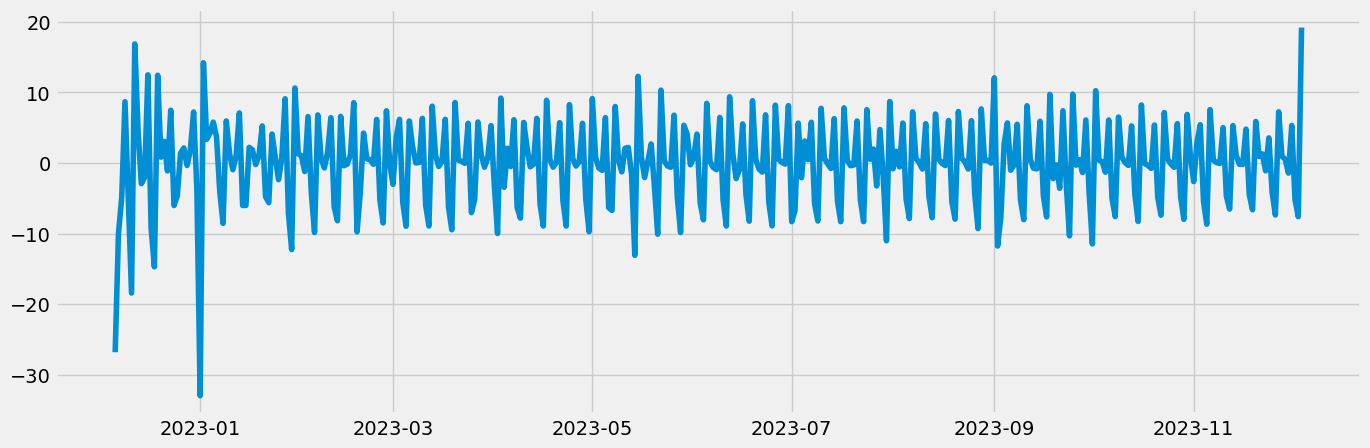

In [45]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [46]:
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                -8.372368e+00
p-value                        2.641147e-13
Number of Lags Used            1.500000e+01
Number of Observations Used    3.480000e+02
Critical Value (1%)           -3.449282e+00
Critical Value (5%)           -2.869881e+00
Critical Value (10%)          -2.571214e+00
dtype: float64


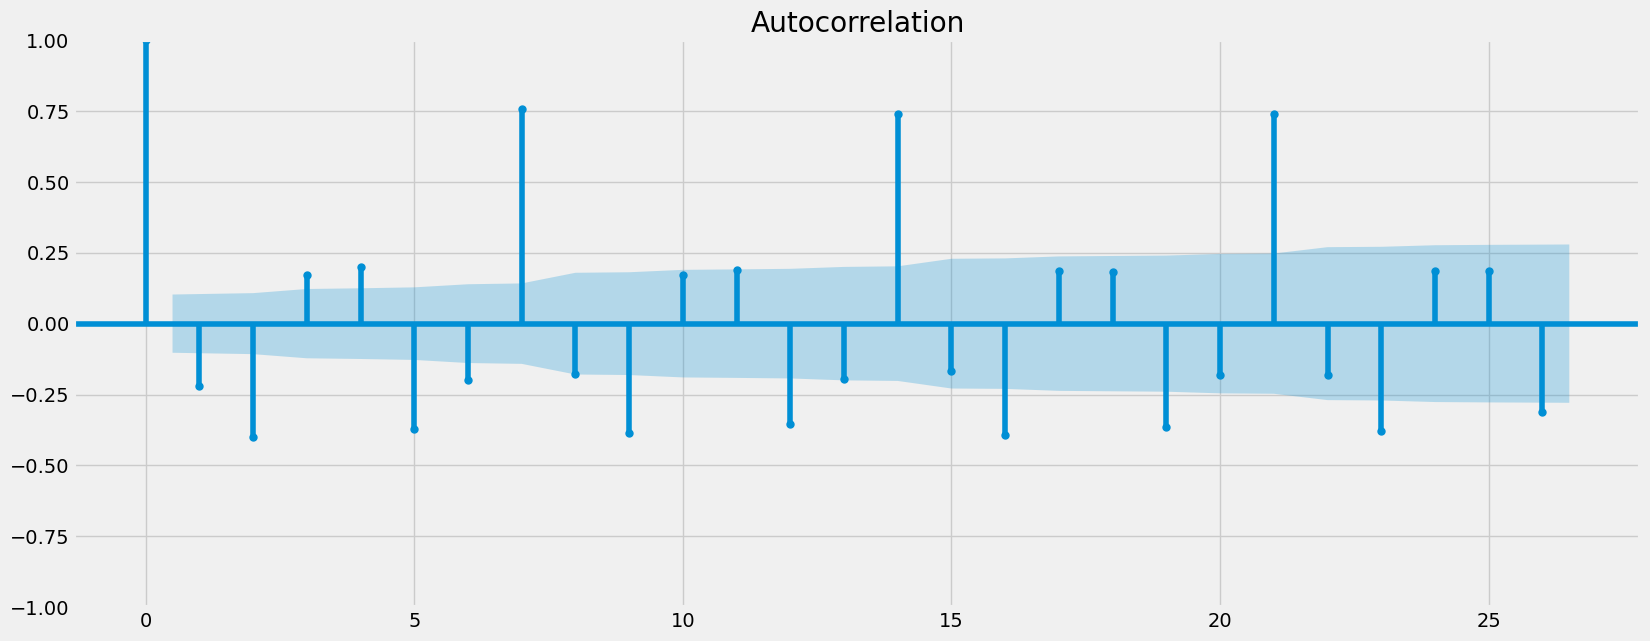

In [47]:
plot_acf(data_diff_2)
plt.show()

# Trying one more time as p-value is less than 0.05 but test stats > critical value

In [48]:
data_diff_3 = data_diff_2 - data_diff_2.shift(1) 
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [49]:
data_diff_3.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [50]:
data_diff_3.head()

,adjusted_price
datetime,
2022-12-07,16.755456
2022-12-08,5.155371
2022-12-09,13.596237
2022-12-10,-13.536705
2022-12-11,-13.576818


In [51]:
data_diff_2.columns

Index(['adjusted_price'], dtype='object')

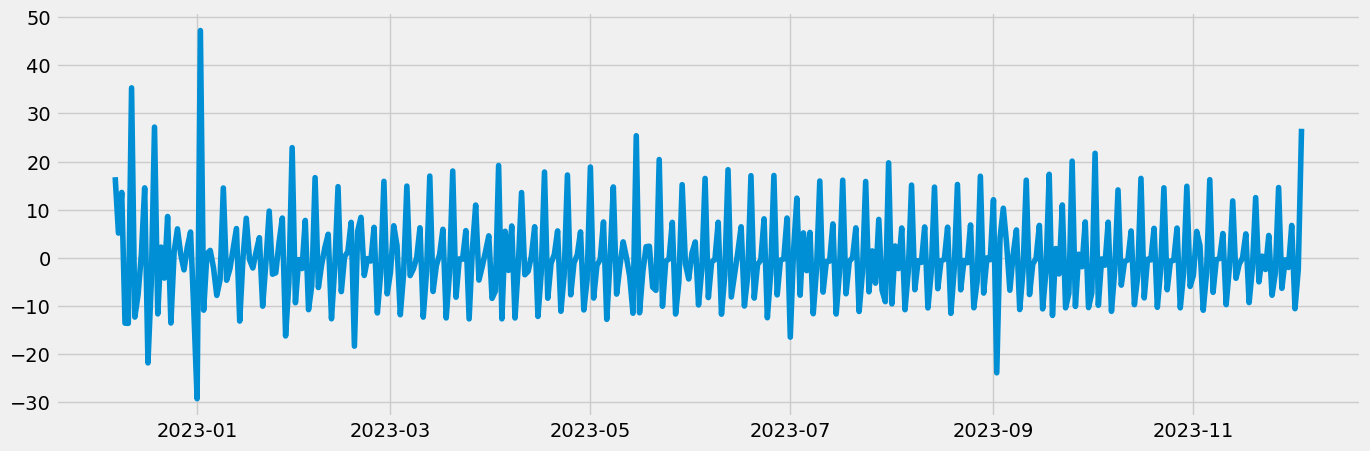

In [52]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_3)

In [53]:
dickey_fuller(data_diff_3)

Dickey-Fuller Stationarity test:
Test Statistic                -9.739006e+00
p-value                        8.595548e-17
Number of Lags Used            1.600000e+01
Number of Observations Used    3.460000e+02
Critical Value (1%)           -3.449392e+00
Critical Value (5%)           -2.869930e+00
Critical Value (10%)          -2.571240e+00
dtype: float64


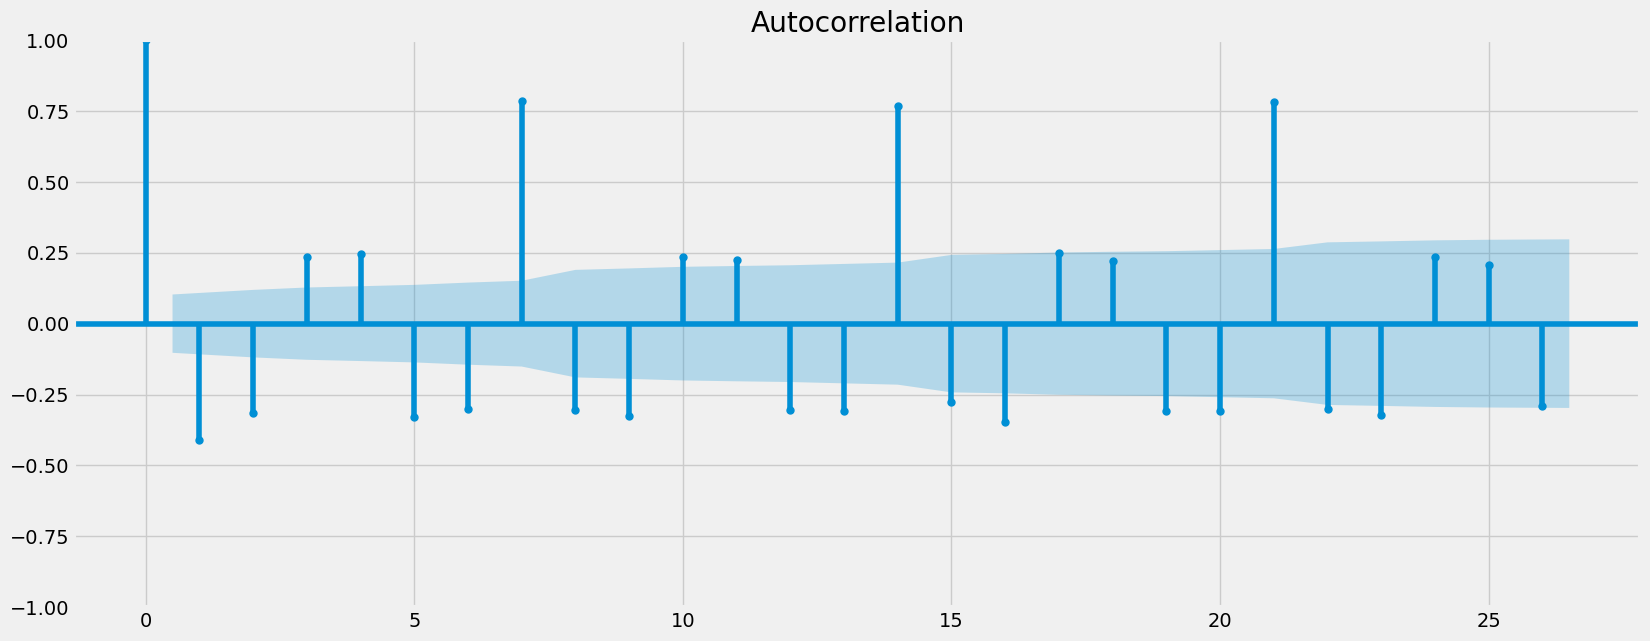

In [54]:
plot_acf(data_diff_3)
plt.show()

p-value and test stats are satisfactory. however Autocorrelation was better in the previous data compared to this one.